### set up

In [1]:
import os
import torch
import shutil
import warnings
import argparse
from PIL import Image
from tqdm import tqdm
import ipywidgets as widgets
from Captioner import Captioner
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device='mps'
print(f'running on {device}')


running on mps


# Inference

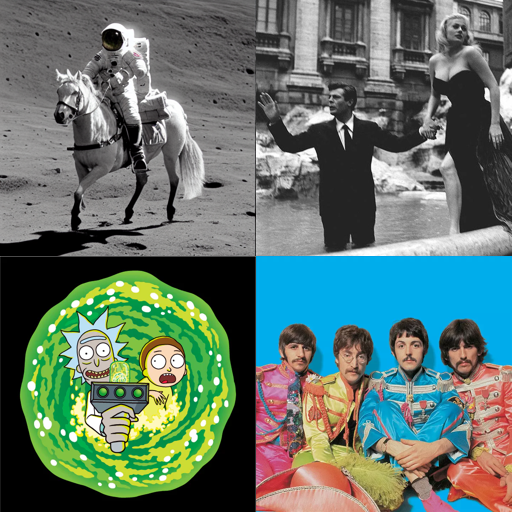

In [2]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid
size = (256,256)
images = [os.path.join('images',f) for f in os.listdir('images')]; images.sort()
pil_images = [Image.open(p).resize(size) for p in images]
grid = image_grid(pil_images, rows=2, cols=2)
display(grid)

## Get captions

In [3]:
models = ['laion/mscoco_finetuned_CoCa-ViT-L-14-laion2B-s13B-b90k',
          'nlpconnect/vit-gpt2-image-captioning',
          'Salesforce/blip-image-captioning-base']
models.sort()
captioners = {model_id:Captioner(model_id, device) for model_id in models}
captions = {k:dict() for k in captioners.keys()}
file_names = os.listdir('images'); file_names.sort()
for k,v in tqdm(captioners.items()):
    for file_name, pil_img in list(zip(file_names,pil_images)):
        captions[k][file_name] = v.get_caption(pil_img)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
100%|██████████| 3/3 [00:15<00:00,  5.22s/it]


In [4]:
print(f"model_id{'':50} file{'':40} caption")
for k,v in captions.items():
    print('')
    for i, (file_name,caption) in enumerate(v.items()):
        if not i: print(f"{k:55} {file_name:40} {caption}")
        else: print(f"{'':55} {file_name:40} {caption}")

model_id                                                   file                                         caption

Salesforce/blip-image-captioning-base                   astronaut-riding-a-horse.png             a man in a white shirt and a white horse
                                                        la-dolce-vita.png                        a woman in a black dress and a man in a suit and tie, standing on a bridge
                                                        ok-rick.png                              rick's rick's rick's rick's rick's rick's rick
                                                        the-beatles.png                          the beatles's new album,'the beatles '

laion/mscoco_finetuned_CoCa-ViT-L-14-laion2B-s13B-b90k  astronaut-riding-a-horse.png             an astronaut is riding a horse on the moon . 
                                                        la-dolce-vita.png                        a man and a woman standing next to each other . 
       

### Generates images from caption

In [5]:
from Generator import Generator
# set up stable diffusion
seed = 42
hparams = {
    'width': 512,
    'height': 512,
    'batch_size': 1,
    'guidance_scale': 7.5,
    'num_inference_steps': 50
}
generator = Generator('CompVis/stable-diffusion-v1-4', device, hparams, seed=seed)

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


#### generate an image for each caption for each model

In [6]:
# set up a dir where to store generated images
save_dir = 'gen_images'
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
    os.mkdir(save_dir)
else:os.mkdir(save_dir)

# generate
generated = {k:dict() for k in captions.keys()}
for k,v in captions.items():
    print(f"\ncaptioner: {k.split('/')[0]}")
    for file_name,caption in v.items():
        print(f'generating {file_name} inferred caption: {caption}')
        latents = generator.generate_conditioned_latents([caption])
        image = generator.decode_latents(latents)
        name = f"{k.split('/')[0]}_{file_name.split('.png')[0]}"
        generator.save_image(image, save_dir=save_dir, names=[name])
        generated[k][file_name] = os.path.join(save_dir,name)
        print(f'stored in {os.path.join(save_dir,name)}')
        


captioner: Salesforce
generating astronaut-riding-a-horse.png inferred caption: a man in a white shirt and a white horse


100%|██████████| 51/51 [00:46<00:00,  1.09it/s]


stored in gen_images/Salesforce_astronaut-riding-a-horse
generating la-dolce-vita.png inferred caption: a woman in a black dress and a man in a suit and tie, standing on a bridge


100%|██████████| 51/51 [00:47<00:00,  1.07it/s]


stored in gen_images/Salesforce_la-dolce-vita
generating ok-rick.png inferred caption: rick's rick's rick's rick's rick's rick's rick


100%|██████████| 51/51 [00:44<00:00,  1.15it/s]


stored in gen_images/Salesforce_ok-rick
generating the-beatles.png inferred caption: the beatles's new album,'the beatles '


100%|██████████| 51/51 [00:45<00:00,  1.12it/s]


stored in gen_images/Salesforce_the-beatles

captioner: laion
generating astronaut-riding-a-horse.png inferred caption: an astronaut is riding a horse on the moon . 


100%|██████████| 51/51 [00:52<00:00,  1.02s/it]


stored in gen_images/laion_astronaut-riding-a-horse
generating la-dolce-vita.png inferred caption: a man and a woman standing next to each other . 


100%|██████████| 51/51 [00:48<00:00,  1.05it/s]


stored in gen_images/laion_la-dolce-vita
generating ok-rick.png inferred caption: a rick and morty picture is shown here . 


100%|██████████| 51/51 [00:47<00:00,  1.08it/s]


stored in gen_images/laion_ok-rick
generating the-beatles.png inferred caption: a group of people sitting next to each other on the ground . 


100%|██████████| 51/51 [00:52<00:00,  1.02s/it]


stored in gen_images/laion_the-beatles

captioner: nlpconnect
generating astronaut-riding-a-horse.png inferred caption: a man riding a horse on a beach 


100%|██████████| 51/51 [00:51<00:00,  1.00s/it]


stored in gen_images/nlpconnect_astronaut-riding-a-horse
generating la-dolce-vita.png inferred caption: a man in a suit and tie standing next to a woman 


100%|██████████| 51/51 [00:48<00:00,  1.06it/s]


stored in gen_images/nlpconnect_la-dolce-vita
generating ok-rick.png inferred caption: a colorful cartoon of a baby with a green and yellow heart 


100%|██████████| 51/51 [00:46<00:00,  1.11it/s]


stored in gen_images/nlpconnect_ok-rick
generating the-beatles.png inferred caption: three men sitting on a bed with a bunch of stuffed animals 


100%|██████████| 51/51 [00:44<00:00,  1.14it/s]


stored in gen_images/nlpconnect_the-beatles


reference


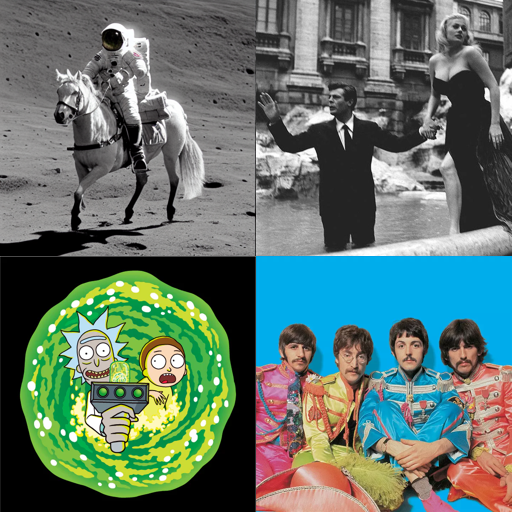

Salesforce/blip-image-captioning-base                        laion/mscoco_finetuned_CoCa-ViT-L-14-laion2B-s13B-b90k       nlpconnect/vit-gpt2-image-captioning


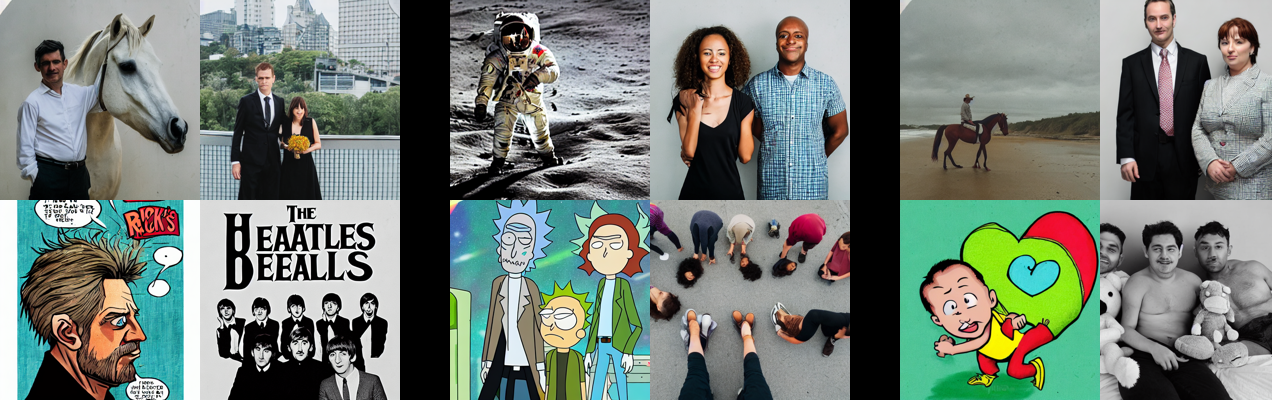

In [7]:
def image_multiple_grid(imgs, rows, cols, offset=50, group=4):
    assert len(imgs) == rows*cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*(w+offset//group), rows*h))
    grid_w, grid_h = grid.size
    prev = 0
    for i, img in enumerate(imgs):
        x = i//rows; y = i%rows
        if i%group==1: x+=1; y-=1
        elif i%group==2: x-=1; y+=1
        grid.paste(img, box=(x*w+i//group*offset, y*h))
    return grid

gen_images = []
for model_prefix,v in generated.items():
    for path in v.values():
        gen_images.append(path+'.png')
size = (200,200)
pil_gen_images = [Image.open(p).resize(size) for p in gen_images]
multiple_grid = image_multiple_grid(pil_gen_images, rows=2, cols=6)
print('reference')
display(grid)
print(f"{models[0]:60} {models[1]:60} {models[2]}")
display(multiple_grid)

# Evaluation
To evaluate athe similarity with the generated images from extracted caption, we will use the cosine similarity w.r.t reference images

In [8]:
import clip
import numpy as np
metric = torch.nn.CosineSimilarity(dim=1)

# encode reference
model, preprocess = clip.load("ViT-B/32", device=device)
reference_images = torch.cat([preprocess(pl_image).unsqueeze(0).to(device) for pl_image in pil_images])
with torch.no_grad():
    image_features_reference = model.encode_image(reference_images)

# encode generated
evaluation=dict()
for i,m in enumerate(models):
    generated_images = torch.cat([preprocess(pl_image).unsqueeze(0).to(device) for pl_image in pil_gen_images[i*4:i*4+4]])
    with torch.no_grad():
        image_features_generated = model.encode_image(generated_images)
        evaluation[m] = metric(image_features_reference,image_features_generated).detach().cpu().numpy()


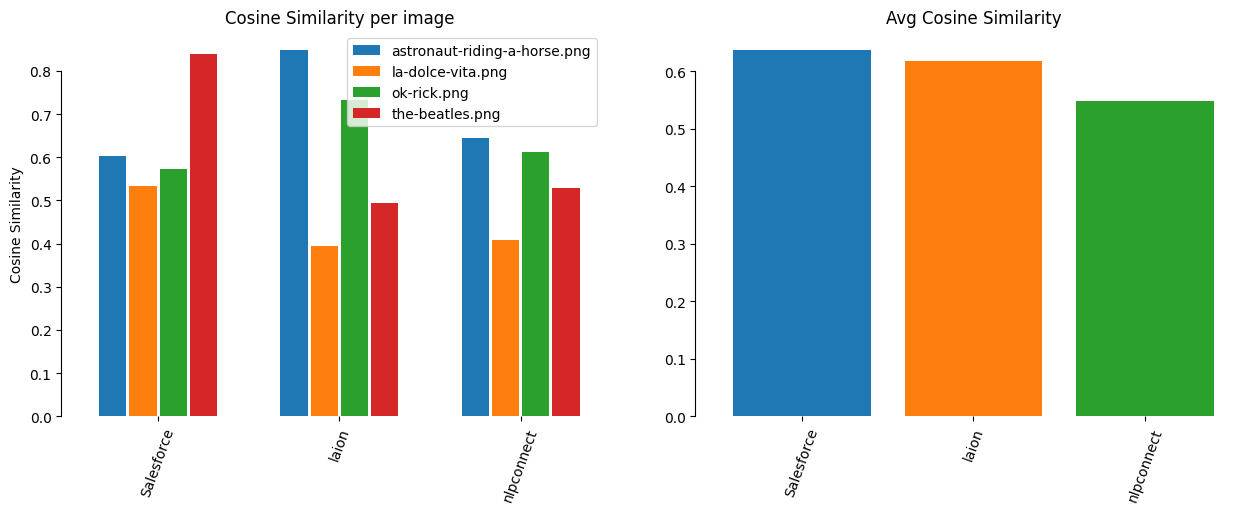

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
# get metrics
fig,ax = plt.subplots(1,2,figsize=(15,5))
offset = .25
labels = list(generated['laion/mscoco_finetuned_CoCa-ViT-L-14-laion2B-s13B-b90k'].keys()); labels.sort()
means = np.empty(3)
for i,(k,v) in enumerate(evaluation.items()):
    X = np.linspace(i+offset,i+offset+1,4)
    ax[0].bar(X, v, width = 0.3, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:4], label=labels)
    offset+=1
    means[i] = v.mean()
ax[0].set_xticks([.75,2.75,4.75], [m.split('/')[0] for m in models], rotation=70)
ax[0].legend(tuple(labels))
ax[0].set_ylabel('Cosine Similarity')
ax[0].set_title('Cosine Similarity per image')

# means
ax[1].bar(np.arange(3),means, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:3] )
ax[1].set_xticks(np.arange(3), [m.split('/')[0] for m in models], rotation=70)
ax[1].set_title('Avg Cosine Similarity')

sns.despine(left=False, bottom=True, trim=True, offset=10)

plt.show()

# Consideration
Is this evaluation complete?
No.
We started with a poor set of images (only 4). Let's take the Salesforce model: its avg score benefits from the caption generated for `the-beatles.png`, since it was the only model which was able to understand the image. This doen't mean that the performance will be the best on a larger dataset.
There is also another consideration to do. 
We generated images with s.d. using only one seed (`42`). But since we are dealing with cosine similarity computed on the features extracted from images, we should consider to have a bunch a seed to start with and then evaluate a larger batch of generated images per caption.

# Improvements
We have evaluated those models wich learned to extract a `caption` and not a `stable diffusion prompt` from an image.
For the sake of research let's evaluate the CLIP Interrogator model, wich was design specifically for extracting a `sd prompt`

In [6]:
from clip_interrogator import Config, Interrogator
ci = Interrogator(Config(clip_model_name="ViT-L-14/openai",device='cpu'))

Loading caption model blip-large...
Loading CLIP model ViT-L-14/openai...
Loaded CLIP model and data in 5.25 seconds.


In [7]:
clip_interr_captions = {}
for f in tqdm(images):
    img = Image.open(f).convert('RGB')
    clip_interr_captions[f.split('images/')[1]] = ci.interrogate_classic(img)

100%|██████████| 4/4 [00:08<00:00,  2.13s/it]


In [8]:
clip_interr_captions

{'astronaut-riding-a-horse.png': 'astronaut on the moon landing paddock with astronaut on the moon, a colorized photo by Storm Thorgerson, shutterstock contest winner, space art, an astronaut riding a horse, astronaut riding horse, astronaut riding a horse',
 'la-dolce-vita.png': 'arafed image of a man and woman in a black and white photo, a matte painting by Mario Cooper, tumblr, mannerism, movie still of james bond, cinematic movie photograph, vintage movie shot',
 'ok-rick.png': 'rick rick rick rick rick rick rick rick rick rick rick rick rick rick rick rick rick rick rick rick rick, vector art inspired by Rick Griffin, featured on deviantart, neo-dada, style of rick & morty, rick and morty pickle rick, rick and morty',
 'the-beatles.png': 'a group of people in colorful costumes and costumes posing for a photo, an album cover inspired by Peter Max, pixabay contest winner, neo-fauvism, 1968 psychedelic, rainbow clothes, red yellow blue'}

In [13]:
clip_inter_gen_images = []
for f, caption in clip_interr_captions.items():
    latents = generator.generate_conditioned_latents([caption])
    image = generator.decode_latents(latents)
    name = f"clip_interrogator_{f.split('.png')[0]}"
    generator.save_image(image, save_dir=save_dir, names=[name])
    clip_inter_gen_images.append(os.path.join(save_dir,name))
clip_inter__grid = image_grid([Image.open(p).resize(size) for p in clip_inter_gen_images], rows=2, cols=2)

100%|██████████| 51/51 [00:53<00:00,  1.05s/it]


Salesforce/blip-image-captioning-base         clip-interrogator              laion/mscoco_finetuned_CoCa-ViT-L-14-laion2B-s13B-b90k nlpconnect/vit-gpt2-image-captioning


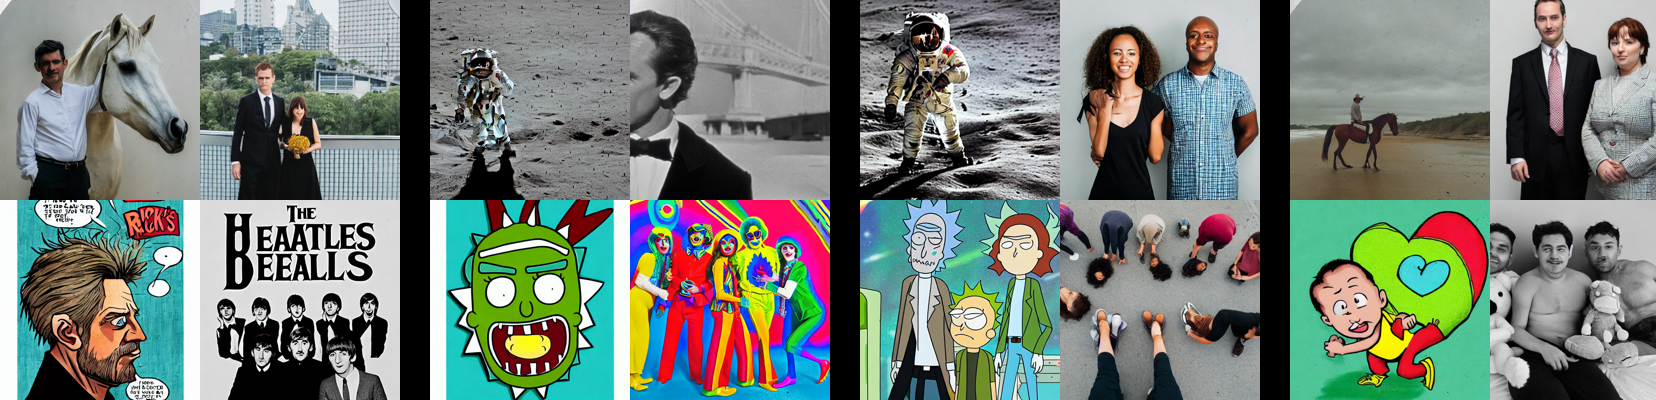

In [43]:
gen_images = [os.path.join(save_dir,f) for f in os.listdir(save_dir)]; gen_images.sort()
size = (200,200)
pil_gen_images = [Image.open(p).resize(size) for p in gen_images]
multiple_grid = image_multiple_grid(pil_gen_images, rows=2, cols=8, offset=30)

print(f"{models[0]:45} {'clip-interrogator':30} {models[1]:50} {models[2]}")
display(multiple_grid)

In [37]:
import clip
import numpy as np
metric = torch.nn.CosineSimilarity(dim=1)
models = ['laion/mscoco_finetuned_CoCa-ViT-L-14-laion2B-s13B-b90k',
          'nlpconnect/vit-gpt2-image-captioning',
          'Salesforce/blip-image-captioning-base',
          'clip_interrogator']
models.sort()

# encode reference
model, preprocess = clip.load("ViT-B/32", device=device)
reference_images = torch.cat([preprocess(pl_image).unsqueeze(0).to(device) for pl_image in pil_images])
with torch.no_grad():
    image_features_reference = model.encode_image(reference_images)

# encode generated
evaluation=dict()
for i,m in enumerate(models):
    generated_images = torch.cat([preprocess(pl_image).unsqueeze(0).to(device) for pl_image in pil_gen_images[i*4:i*4+4]])
    with torch.no_grad():
        image_features_generated = model.encode_image(generated_images)
        evaluation[m] = metric(image_features_reference,image_features_generated).detach().cpu().numpy()


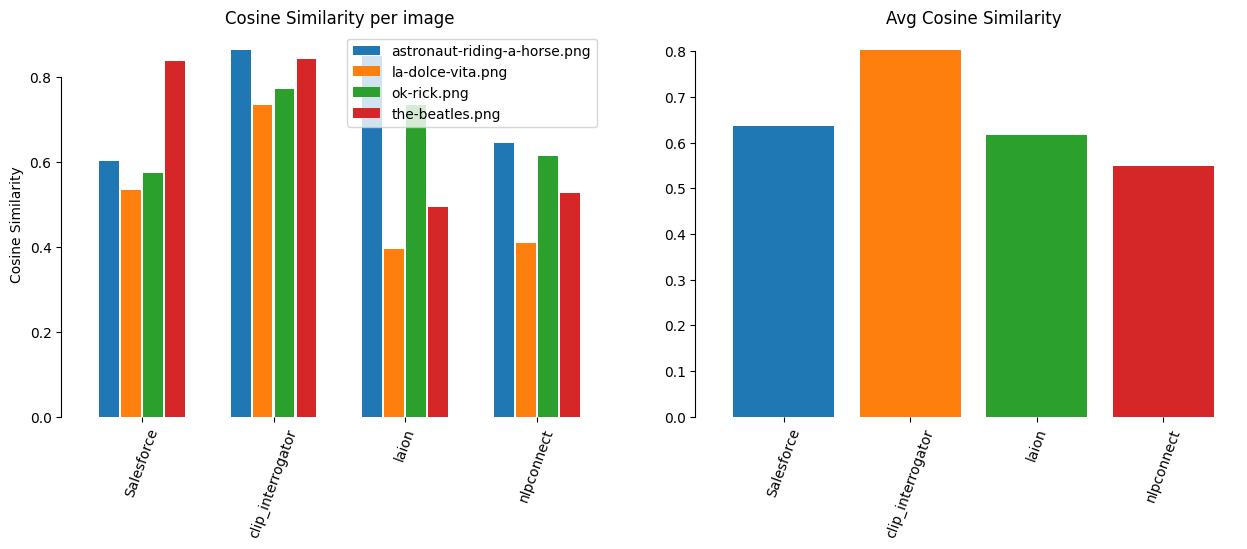

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
# get metrics
fig,ax = plt.subplots(1,2,figsize=(15,5))
offset = .25
labels = [f.split('images/')[1] for f in images]; labels.sort()
means = np.empty(4)
for i,(k,v) in enumerate(evaluation.items()):
    X = np.linspace(i+offset,i+offset+1,4)
    ax[0].bar(X, v, width = 0.3, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:4], label=labels)
    offset+=1
    means[i] = v.mean()
ax[0].set_xticks([.75,2.75,4.75,6.75], [m.split('/')[0] for m in models], rotation=70)
ax[0].legend(tuple(labels))
ax[0].set_ylabel('Cosine Similarity')
ax[0].set_title('Cosine Similarity per image')

# means
ax[1].bar(np.arange(4),means, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:4] )
ax[1].set_xticks(np.arange(4), [m.split('/')[0] for m in models], rotation=70)
ax[1].set_title('Avg Cosine Similarity')

sns.despine(left=False, bottom=True, trim=True, offset=10)

plt.show()

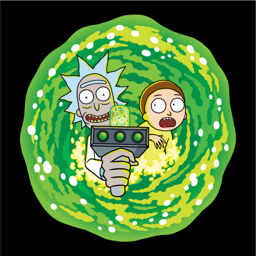

In [40]:
pil_images[2]